# CS109b Final Project

# Milestone 3


by Danqing Wang, Wenshan Zheng, Zecai Liang


---

# Part 1. Feature Engineering

### Variable Group 1: ['year', 'rating', 'votes', 'popularity_TMDB', 'runtime_TMDB']
- variable ['year', 'rating', 'votes'] have missing values as 'NaN': we impute the missing value in training and test data with the mean value of training data
- [popularity_TMDB'] have missing values as 0: we impute the missing value in training and test data with the mean value of training data
- ['runtime_TMDB'] have missing values as 0 and as 'NaN': we perform the same mean imputation

### Variables Group 2: ['title', 'plot', 'plot outline', 'overview_TMDB', 'tagline_TMDB']
- we combine all the text information for one movie, split the paragraph of string into bag-of-words, and return the top 30 PCs
- we used the PCA model trained from the training data to transform the test data

### Variable Group 3: ['mpaa']
- we extracted the text as the reason for 'mpaa', and applied similar text analysis as variable group 2, and return return the top 10 PCs

### Variable Group 4: ['director', 'cast', 'production company', 'writer']
- ['director', 'writer']: We analyse the training data and rank the top few most representative directors/writer in each genre. We extract the top director/writer from each genre and use them as new predictor columns, and transform the training data into a new dataframe using one-hot-encoding. We also form a similar dataframe for the test dataset using the same columns. Since the dataframes are sparse, we expect some of the directors/writers selected by the training data analysis not represented at all in the test dataset, and therefore will have columns with NULL values. We replace these NULL values with 0s.
- ['cast', 'production companies']: We analyse the training data and rank the top 5 most representative cast members/production companies in each genre. We extract the lists of cast members/production companies and use one-hot-encoding to form a dataframe of 1s and 0s consisting of all movies in the training set. We then perform PCA on the dataframe and select the top five PCs for both cast and production companies. We then use these PCs to transform the test dataset into the new basis, and prepare it for model fitting.

### Variables Group 5: ['animation department', 'original music']
- we extract the number of person ID for both department, representing the number of staff working there

### Variables Group 6: ['countries']
- we return the number of countries for each movie with variable name 'country_n'
- we also record if the movie is produced in one of the following major countries: ['usa', 'france', 'uk', 'germany', 'italy', 'canada', 'japan', 'india', 'spain'] 

### Response: ['genres']

- There are in total 28 genres in imdb, which are: 'Action', 'Adventure', 'Comedy', 'Crime', 'Fantasy', 'Family', 'Romance', 'Horror', 'Reality-TV', 'Western', 'Documentary', 'Biography', 'News', 'Film-Noir', 'Drama', 'Animation', 'Sci-Fi', 'Thriller', 'Short', 'Mystery', 'Sport', 'War', 'History', 'Game-Show', 'Music', 'Musical' and 'Talk-Show'.
Becaues 'Music' and 'Musical' is very similar, we combine these 2 genres thus we have 27 genres.

- In tmdb, there are 19 genres. However, most genres in tmdb are included in imdb, the only exception is 'TV movie' thus it is added to genre list and now we have 28 genres.

- Then we assign each movie's genres into a multi binomial genre list with 28 values correspongding to if it belongs to each of these 28 genres.

- Then we found that 'TV movie', 'Game-Show', 'Reality-TV', 'Talk-Show', 'News' and 'Film-Noir' only have less then 300 movies assigned, which is far less than our 25K moives number, so we combine these 6 genres into a genre'Other'.

- After these, we have in total 23 genres which are 'Action', 'Adventure', 'Comedy', 'Crime', 'Fantasy', 'Family', 'Romance', 'Horror', 'Western', 'Documentary', 'Biography', 'Drama', 'Animatio', 'Sci-Fi', 'Thriller', 'Short', 'Mystery', 'Sport', 'War', 'History', 'Music', 'Foreign' and 'Other'.

In [6]:
import pandas as pd

df_feature = pd.read_csv("feature_final.csv", index_col = 0)
df_genre = pd.read_csv("genre_final.csv", index_col = 0)

In [73]:
x_train, x_test, y_train, y_test = generate_train_test_data(feature_data = df_feature, genre_data = df_genre, 
                                                             n_sample = 5000, train_ratio = 0.5, ran_state = 0)

In [80]:
x_train.to_csv("x_train.csv")
x_test.to_csv("x_test.csv")
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")

### Run functions in the supplement before running this function

In [72]:
###### Function to generate train and test data for classification models #######
### ------ Input ---------- ###
# feature_data: a data frame with original features from IMDB and TMDB
# genre_data: a data grame with genres (already merged turned into one-hot coding), 
#             matching the feature_data by 'imdb_ids'
# n_sample: the number of data points to sample from the input data frame to fit model
# train_ratio: the percentage of training data among sampled data
# ran_state: seed for random sampling


def generate_train_test_data(feature_data, genre_data, n_sample = 5000, train_ratio = 0.5, ran_state = 0):
    
    import pandas as pd
    import numpy as np
    import re
    import random
    import warnings
    warnings.filterwarnings("ignore")

    # ------------------------------------------------------------------------------------------------------ #     

    ### sample data ###
    
    data_x = feature_data.sample(n = n_sample, random_state = ran_state)
    data_y = genre_data.ix[data_x.index.values,]
    
    ### split into train and test data ###
    k = int(n_sample * train_ratio)
    
    x_train = data_x[:k]
    x_test = data_x[k:]
    y_train = data_y[:k]
    y_test = data_y[k:]
    
    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Variable Group 1: ['year', 'rating', 'votes', 'popularity_TMDB', 'runtime_TMDB'] ###

    val_group1 = ['year', 'rating', 'votes', 'popularity_TMDB', 'runtime_TMDB']
    
    ## missing value imputation ##
    # use the mean from train data to fill test data 

    # 'year', 'rating', 'votes' have missing values as 'NaN', fill by column mean
    x_train.ix[x_train['year'].isnull(), 'year'] = x_train['year'].mean()
    x_test.ix[x_test['year'].isnull(), 'year'] = x_train['year'].mean()

    x_train.ix[x_train['rating'].isnull(), 'rating'] = x_train['rating'].mean()
    x_test.ix[x_test['rating'].isnull(), 'rating'] = x_train['rating'].mean()

    x_train.ix[x_train['votes'].isnull(), 'votes'] = x_train['votes'].mean()
    x_test.ix[x_test['votes'].isnull(), 'votes'] = x_train['votes'].mean()

    # 'popularity_TMDB' have missing values as 0, replace by column mean
    x_train.ix[x_train['popularity_TMDB'] == 0, 'popularity_TMDB'] = x_train['popularity_TMDB'].mean()
    x_test.ix[x_test['popularity_TMDB'] == 0, 'popularity_TMDB'] = x_train['popularity_TMDB'].mean()
    
    # 'runtime_TMDB' have missing values as 0 and 'NaN'
    value = x_train['runtime_TMDB'].mean()
    x_train.ix[x_train['runtime_TMDB'] == 0, 'runtime_TMDB'] = value
    x_train.ix[x_train['runtime_TMDB'].isnull(), 'runtime_TMDB'] = value
    x_test.ix[x_test['runtime_TMDB'] == 0, 'runtime_TMDB'] = value
    x_test.ix[x_test['runtime_TMDB'].isnull(), 'runtime_TMDB'] = value
    
    
    ## use x_train_new, x_test_new to record the transformed data
    x_train_group1 = x_train[val_group1]
    x_test_group1 = x_test[val_group1]

    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Variables Group 2: ['title', 'plot', 'plot outline', 'overview_TMDB', 'tagline_TMDB', 'mpaa_reason'] ###

    ## combine the text in ['title', 'plot', 'plot outline', 'overview_TMDB', 'tagline_TMDB']

    x_train_text = x_train['title'].str.cat([x_train['plot'], x_train['plot outline'], 
                              x_train['overview_TMDB'], x_train['tagline_TMDB']], 
                              na_rep = " ")
    x_train_text = pd.DataFrame(x_train_text, index = x_train.index)

    x_test_text = x_test['title'].str.cat([x_test['plot'], x_train['plot outline'], 
                              x_test['overview_TMDB'], x_test['tagline_TMDB']], 
                              na_rep = " ")
    x_test_text = pd.DataFrame(x_test_text, index = x_test.index)

    ## apply text analysis on combined text and return the top 30 PCs
    x_train_group2, x_test_group2 = text_analysis(x_train_text, x_test_text,
                                             val_name = 'text', n_components = 30)

    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Variables Group 3: [mpaa_reason'] ###

    ## apply text analysis on 'mpaa_reason' and return thr PCs that cover 60% variance
    x_train_mpaa = pd.DataFrame(x_train['mpaa_reason'], index = x_train.index)
    x_test_mpaa = pd.DataFrame(x_test['mpaa_reason'], index = x_test.index)
    
    x_train_group3, x_test_group3 = text_analysis(x_train_mpaa, x_test_mpaa,
                                             val_name = 'mpaa', n_components = 10)
    
    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Variables Group 4: ['director', 'cast', 'production company', 'writer'] ###
    
    x_train_group4_1, x_test_group4_1 = top_features(train_feature = x_train, train_genre = y_train,
                                        test_feature = x_test, test_genre = y_test,
                                        val_name = 'director',
                                        val_n = 1)
    
    x_train_group4_2, x_test_group4_2 = top_features(train_feature = x_train, train_genre = y_train,
                                        test_feature = x_test, test_genre = y_test,
                                        val_name = 'writer',
                                        val_n = 1)

    x_train_group4_3, x_test_group4_3 = top_features_pca(train_feature = x_train, train_genre = y_train,
                                        test_feature = x_test, test_genre = y_test,
                                         val_name = 'cast',
                                         val_n = 5,
                                         pca_n = 10)

    x_train_group4_4, x_test_group4_4 = top_features_pca(train_feature = x_train, train_genre = y_train,
                                        test_feature = x_test, test_genre = y_test,
                                         val_name = 'production companies',
                                         val_n = 5,
                                         pca_n = 5)
     
    x_train_group4 = pd.concat([x_train_group4_1, x_train_group4_2,
                               x_train_group4_3, x_train_group4_4], axis = 1)
    x_test_group4 = pd.concat([x_test_group4_1, x_test_group4_2,
                               x_test_group4_3, x_test_group4_4], axis = 1)
    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Variables Group 5: ['animation department', 'original music'] ###
    
    # return x_train_group5, x_test_group5
    
    x_train_group5_1, x_test_group5_1 = feature_to_count(train_feature = x_train, train_genre = y_train,
                                        test_feature = x_test, test_genre = y_test,
                                        val_name = 'animation department')

    x_train_group5_2, x_test_group5_2 = feature_to_count(train_feature = x_train, train_genre = y_train,
                                        test_feature = x_test, test_genre = y_test,
                                        val_name = 'original music')
    
    
    x_train_group5 = pd.concat([x_train_group5_1, x_train_group5_2], axis = 1)
    x_test_group5 = pd.concat([x_test_group5_1, x_test_group5_2], axis = 1)
    
    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Variables Group 6: ['countries'] ###
    x_train_country = text_to_matrix(pd.DataFrame(x_train['countries'], index = x_train.index))
    x_test_country = text_to_matrix(pd.DataFrame(x_test['countries'], index = x_test.index))
    
    x_train_country.index = x_train.index
    x_test_country.index = x_test.index
    
      # count the number of countries for each movie
    x_train_group6_1 = pd.DataFrame(x_train_country.sum(axis = 1), columns = ['country_n'])
    x_test_group6_1 = pd.DataFrame(x_test_country.sum(axis = 1), columns = ['country_n'])
    
      # keep the information of major countries
    country_major = ['usa', 'france', 'uk', 'germany', 'italy', 'canada', 'japan', 'india', 'spain']
    x_train_group6_2 = x_train_country[country_major]
    x_train_group6_2.columns = ['country_usa', 'country_france', 
                                 'country_uk', 'country_germany',
                                 'country_italy', 'country_canada', 
                                 'country_japan', 'country_india', 'country_spain'] 
    x_test_group6_2 = x_test_country[country_major]
    x_test_group6_2.columns = ['country_usa', 'country_france', 
                                 'country_uk', 'country_germany',
                                 'country_italy', 'country_canada', 
                                 'country_japan', 'country_india', 'country_spain']
    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Combine Engineered Features ###
    x_train_new = pd.concat([x_train_group1, x_train_group2, x_train_group3, 
                             x_train_group4, x_train_group5,
                             x_train_group6_1, x_train_group6_2], axis=1)
    
    x_test_new = pd.concat([x_test_group1, x_test_group2, x_test_group3, 
                             x_test_group4, x_test_group5,
                            x_test_group6_1, x_test_group6_2], axis=1)
     
    return (x_train_new, x_test_new, y_train, y_test)

## Supplement: functions that are used in the above meta-function:

In [12]:
##### part of the function to apply text analysis to a data series #####
#### to transform a text paragraph to bag-of-words than to one-hot coding


#----------------------------------------------------------------------------------------------------
### Input ###
        # data: a series for text analysis

        
### Output ###
        # the transformed data in one-hot coding
#----------------------------------------------------------------------------------------------------        



def text_to_matrix(data):
    
    import pandas as pd
    import numpy as np
    import re
    import warnings
    warnings.filterwarnings("ignore")
    
    
    
    ## --------------- Bag-of-Words --------------- ##
    
    ## string to list
    import re
    col_words = []
    
    for i in range(data.shape[0]):
    
        if type(data.iloc[i,0]) == str: 
            letters_only = re.sub("[^a-zA-Z]", " " , data.iloc[i,0]) # remove non-letter
            lower_case = letters_only.lower().split()   # Convert to lower case # Split into words
            
            # avoid downloading nltk
            # from NLTK stopwords https://pythonprogramming.net/stop-words-nltk-tutorial/
            stops = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 
                     'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 
                     'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 
                     's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 
                     'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 
                     'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 
                     'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 
                     'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 
                     'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 
                     'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 
                     'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 
                     'it', 'how', 'further', 'was', 'here', 'than'} 
            meaningful_words = [w for w in lower_case if not w in stops]  # Remove stop words from "words"
            
            words = ( " ".join(meaningful_words))
    
        else: words = "NA"
       
        col_words.append(words)
        
        
    
    ## list to vector
    from sklearn.feature_extraction.text import CountVectorizer

    # Initialize the "CountVectorizer" object
    vectorizer = CountVectorizer(analyzer = "word",   
                                 tokenizer = None,    
                                 preprocessor = None, 
                                 stop_words = None,   
                                 max_features = 20000)

    data_array = vectorizer.fit_transform(col_words)
    data_array = pd.DataFrame(data_array.toarray())
    data_array.columns = vectorizer.get_feature_names()
    
    return data_array
    

### Function for Variable ['title', 'plot', 'plot outline', 'overview_TMDB', 'tagline_TMDB', 'mpaa_reason']

In [11]:
##### Function to apply text analysis to a column with `colname` in the data file `filename`


#----------------------------------------------------------------------------------------------------
### Input ###
        # train: the train data in one-hot coding
        # test: the test data in one-hot coding
        # val_name:  variable name that's used in naming the columns as "val_name_PCi"
        # n_components: if value is int, the number of PCs to return
                       # if value between (0,1), the variance explained by the PCs returnd
        
### Output ###
        # data matrix of engineered feature, one for train data and one for test data
#----------------------------------------------------------------------------------------------------        


def text_analysis(train, test, val_name, n_components):
    
    ## turn each text paragraph into one-hot coding
    train_array = text_to_matrix(train)
    test_array = text_to_matrix(test)
    
    ## take the union set of words in train and text data as column
    ## words that don't show up are assigned 0
    align_column = pd.concat([train_array,test_array], axis=0).fillna(0)
    # keep only the gas-of-words from training data
    align_column = align_column[train_array.columns]
    
    ## split into train and text after aligning the columns
    train_array = align_column.iloc[0:train_array.shape[0], ]
    test_array = align_column.iloc[train_array.shape[0]:, ]
    
    ## PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components = n_components)
    pca.fit(train_array)
    train_new = pd.DataFrame(pca.transform(train_array), index = train.index)
    test_new = pd.DataFrame(pca.transform(test_array), index = test.index)
    test_new = test_new.fillna(value = 0)
    
    col_names = []
    for i in range(train_new.shape[1]):
        i_name = val_name + "_PC" + str(i+1)
        col_names.append(i_name)
        
    train_new.columns = col_names
    test_new.columns = col_names
    
    return (train_new, test_new)
    

### Function used in the following functions

In [16]:
### Function to convert to string list [u'Action', u'Adventure', u'Fantasy'] into dummy coding
## input: 
           # data = orignal data frame, 
           # val_name = name of the variable
## output: a data frame

def string_to_vector(data, val_name):
    
    from sklearn.feature_extraction.text import CountVectorizer
    
    # convert any np.nan to a string 'nan'
    data[val_name][pd.isnull(data[val_name])] = 'nan'
    
    vectorizer = CountVectorizer(analyzer = "word",   
                                             tokenizer = None,    
                                             preprocessor = None, 
                                             stop_words = None,   
                                             max_features = 50000)

    val_data = vectorizer.fit_transform(data[val_name])
    df_val = pd.DataFrame(val_data.toarray())
    df_val.columns = vectorizer.get_feature_names()
    df_val.index = data.index
    
    return df_val

### Function for Variable ['director', 'writer']

In [17]:
### Function considers a particular feature of interest (e.g. director, writer) 
### and picks out the top val_n most important value in each genre
### Input: 
# - train_feature: df with 2500 train observations, all feature columns, indexed with imdb_ids
# - train_genre: df with 2500 train observations, all genre columns, indexed with imdb_ids
# - test_feature: df with 2500 test observations, all feature columns, indexed with imdb_ids 
# - test_genre: df with 2500 test observations, all genre columns, indexed with imdb_ids
# - val_name # feature of interest, eg. director
# - val_n # number of top values to take, eg. 1
### Output:
# - train_val: df with 2500 train observations, new columns of top directors, indexed with imdb_ids
# - test_val: df with 2500 test observations, new columns of top directors, indexed with imdb_ids

def top_features(train_feature, train_genre, test_feature, test_genre,
                val_name = 'director', val_n = 1):

    # convert feature of interest into dummy variables in train set and test set
    feature_val_train = string_to_vector(train_feature, val_name)
    feature_val_test = string_to_vector(test_feature, val_name)

    # create a dataframe with columns consisting of all directors and all genres, rows are movie entries 
    feature_val_genre = pd.concat([feature_val_train, train_genre], axis = 1)
    
    # generate list of top directors in each genre 
    val_list = []
    for i in train_genre.columns:
        sum_val_in_genre = feature_val_genre.ix[feature_val_genre[i] == 1, range(feature_val_train.shape[1]-1)].sum(axis = 0)
        sum_val_in_genre_sorted = sum_val_in_genre.sort(inplace=False, ascending = False)
        for j in range(val_n):
            top_val_in_genre = sum_val_in_genre_sorted.index[j]
            val_list.append(top_val_in_genre)      

    # output dataframes of movies with new columns
    train_val = feature_val_train.ix[:, val_list] 
    test_val = feature_val_test.ix[:, val_list]
    
    # replace any NA vaalues in the test set with 0
    test_val = test_val.fillna(value = 0)
    
    # rename columns as director1, director2, etc
    col_names = []
    for i in range(train_val.shape[1]):
            i_name = val_name + str(i)
            col_names.append(i_name)
    train_val.columns = col_names
    test_val.columns = col_names

    return(train_val, test_val)

### Function for Variable ['cast','production company']

In [18]:
### Function considers a particular feature of interest (e.g. cast, production companies) 
### and picks out the top val_n most important value in each genre
### and then performs PCA, picks out the top pca_n numbers of components
### Input: 
# - train_feature: df with 2500 train observations, all feature columns, indexed with imdb_ids
# - train_genre: df with 2500 train observations, all genre columns, indexed with imdb_ids
# - test_feature: df with 2500 test observations, all feature columns, indexed with imdb_ids 
# - test_genre: df with 2500 test observations, all genre columns, indexed with imdb_ids
# - val_name # feature of interest, eg. director
# - val_n # number of top values to take, eg. 5
# - pca_n # number of pca components to retain, eg. 5
### Output:
# - train_val: df with 3000 train observations, columns as pca components, indexed with imdb_ids
# - test_val: df with 2000 test observations, columns as pca components, indexed with imdb_ids

def top_features_pca(train_feature, train_genre, test_feature, test_genre,
                     val_name = 'cast',
                     val_n = 5,
                     pca_n = 5):
    
    ## Step 1, pick top casts in each genre using top_feature function 
    train_val, test_val = top_features(train_feature = train_feature,
                    train_genre = train_genre,
                    test_feature = test_feature,
                    test_genre = test_genre,
                    val_name = val_name,
                    val_n = val_n)
    
    # replace any NA values in test set with 0 (or will have problem in pca.transform)
    test_val = test_val.fillna(value=0)

    ## Step 2, perform PCA
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components = pca_n, svd_solver = "full") # keep the first pca_n PCs
    pca = pca.fit(train_val)
    train_pca = pd.DataFrame(pca.transform(train_val), index = train_val.index)
    test_pca = pd.DataFrame(pca.transform(test_val), index = test_val.index)

    ## Step 3, rename the columns as cast_PC1, cast_PC2, etc. 
    col_names = []
    for i in range(pca_n):
            i_name = val_name + "_PC" + str(i+1)
            col_names.append(i_name)
    train_pca.columns = col_names
    test_pca.columns = col_names

    return (train_pca, test_pca)

### Function for Variable ['animatino department', 'original music']

In [19]:
### Function considers a particular feature of interest (e.g. animation department, original music) 
### and counts the number of member occurance in each movie 
### Input: 
# - train_feature: df with 2500 train observations, all feature columns, indexed with imdb_ids
# - test_feature: df with 2500 test observations, all feature columns, indexed with imdb_ids 
# - val_name # feature of interest, eg. animation department
### Output:
# - train_count: df with 2500 train observations, new column of count, indexed with imdb_ids
# - test_count: df with 2500 test observations, new column of count, indexed with imdb_ids

def feature_to_count(train_feature, train_genre, test_feature, test_genre,
                val_name = 'animation department'):
    
    # convert column to number of counts of members 
    train_count = pd.DataFrame(string_to_vector(train_feature, val_name).ix[:,:-1].sum(axis=1), 
                               columns = {val_name + ' count'})
    test_count = pd.DataFrame(string_to_vector(test_feature, val_name).ix[:,:-1].sum(axis=1), 
                              columns = {val_name + ' count'})
    
    return(train_count, test_count)

---
# Part 2. Performance Metrics

ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

We considered three metircs to use:

#### F1 Score: #### 
- For each movie to be predicted, we use the `f1_score` function from `sklearn.metrics` package to compare the predicted value (23-long vector with 0 and 1 for each genre) and true value. To start with, we can calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
- We choose F1 score because we care about both false positive and false negative mistakes. For now we are giving them the same weights, so we take the harmonic mean of precision and recall. But this can be further adjusted depending on the application of this prediction (whether it's worse to mis-classified a genre or to miss a genre).

#### weighted F1 Score: #### 
- We can also use the 'weighted average' for F1 score: calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This accounts for inbalanced data.

#### IoU Score ####
- We also exlored another metric: Intersection over Union (IoU). Accuracy score here is defined as (intersection between real and predicted vectors) / (union between real and predicted vectors). It also moniters both false positive and false negtive mistakes.

For the following model tuning, we'll use unweighted F1 score.

#### The function to calculate averaged F1 score:

In [235]:
# Function f1_genre
# input: two pandas dataframes, 
    # genre_real: predicted values
    # genre_predict: real values
# output: mean f1 score of each class
def f1_genres(genre_real, genre_predict):
    count_row = len(genre_real)
    if count_row == 0:
        print "No data in dataframe!"
        return
    if count_row != len(genre_predict):
        print "Different length of predicted and real dataframes!"
        return
    count_col = len(genre_real.columns)
    if count_col == 0:
        print "No data in dataframe!"
        return
    if count_col != len(genre_predict.columns):
        print "Different genres of predicted and real dataframes!"
        return
    score = 0
    for i in range(count_col):
        score += f1_score(genre_real[genre_real.columns.values[i]], genre_predict[genre_predict.columns.values[i]])
    score = score/count_col
    return(score)

#### Function to calculate the aveage IoU score:

In [209]:
# Function score_genre
# input: two pandas dataframes, 
    # genre_real: predicted values
    # genre_predict: real values
# output: mean accuracy of prediction
# accuracy score here is defined as 
    # (intersection between real and predicted vectors) / (union between real and predicted vectors)

def score_genre(genre_real, genre_predict):
    count_row = len(genre_real)
    if count_row == 0:
        print "No data in dataframe!"
        return
    if count_row != len(genre_predict):
        print "Different length of predicted and real dataframes!"
        return
    count_col = len(genre_real.columns)
    if count_col == 0:
        print "No data in dataframe!"
        return
    if count_col != len(genre_predict.columns):
        print "Different genres of predicted and real dataframes!"
        return
    accuracy_genre = 0.0
    for i in range(count_row):
        count_intersection = 0.0
        count_unity = 0.0
        accuracy_temp = 0.0
        for j in range(len(genre_real.columns)):
            if genre_real.iloc[i][j] == 1 or genre_predict.iloc[i][j] == 1:
                count_unity += 1.0
            if genre_real.iloc[i][j] == 1 and genre_predict.iloc[i][j] == 1:
                count_intersection += 1.0 
        if count_unity == 0: # a few ovservations has no genre assigned, delete these values from evaluation
            count_row = count_row - 1
        else:
            accuracy_temp = count_intersection / count_unity
            accuracy_genre += accuracy_temp
    if count_row <= 0:
        print "No meaning value!"
        return
    return (accuracy_genre/count_row)

---
# Part 3. Benchmark Models

In [215]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import f1_score
import scipy as sp
from sklearn.cross_validation import KFold
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [ ]:
### read in datasets
x_test = pd.read_csv('x_test.csv',index_col=0)
x_train = pd.read_csv('x_train.csv',index_col=0)
y_test = pd.read_csv('y_test.csv',index_col=0)
y_train = pd.read_csv('y_train.csv',index_col=0)

In [ ]:
### standardize
scaler = preprocessing .StandardScaler().fit(x_train)
x_train_np = scaler.transform(x_train)
x_test_np = scaler.transform(x_test)

indexs_train = x_train.index
indexs_test = x_test.index
x_train = pd.DataFrame(x_train_np, index = indexs_train, columns = x_train.columns)
x_test = pd.DataFrame(x_test_np, index = indexs_test, columns = x_test.columns)

## 3.1 Baseline Model
We'll quickly go through classification models without feature selection or model tuning, and have a sense of their base peformance.

#### methods support multilabel classification:

In [238]:
# KNN
random.seed(0)
knn = KNN(n_neighbors=1)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
y_pred= pd.DataFrame(y_pred, columns = y_test.columns.values)

score_knn = f1_genres(y_test, y_pred)
print "F1 Score:", score_knn

F1 Score: 0.200094213238


In [237]:
# Decision Tree
random.seed(0)
tree = DecisionTree(max_depth=6)
tree.fit(x_train, y_train)

y_pred = tree.predict(x_test)
y_pred= pd.DataFrame(y_pred, columns = y_test.columns.values)

score_tree = f1_genres(y_test, y_pred)
print "F1 Score:", score_tree

F1 Score: 0.171548389046


In [239]:
# Random Forest
random.seed(0)
rf = RandomForest()
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_pred= pd.DataFrame(y_pred, columns = y_test.columns.values)

score_rf = f1_genres(y_test, y_pred)
print "F1 Score:", score_rf

F1 Score: 0.139195833822


#### Other classifiers that don't support multilabel classification, thus need to fit classifier for each genre, then combine:

In [240]:
# Unweighted logistic regression
random.seed(0)

genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values

for col in y_train.columns:
    unweighted_logistic = LogisticRegression()
    unweighted_logistic.fit(x_train, y_train[col])
    genre_pred[col]= unweighted_logistic.predict(x_test)

score_unweighted_log = f1_genres(y_test, y_pred)
print "F1 Score:", score_unweighted_log

F1 Score: 0.139195833822


In [241]:
# weighted logistic regression
random.seed(0)
genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values

for col in y_train.columns:
    weighted_logistic = LogisticRegression(class_weight='balanced')
    weighted_logistic.fit(x_train, y_train[col])
    genre_pred[col]= weighted_logistic.predict(x_test)

score_weighted_log = f1_genres(y_test, y_pred)
print "F1 Score:", score_weighted_log

F1 Score: 0.139195833822


In [242]:
#LDA
random.seed(0)
genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values

for col in y_train.columns:
    lda = LDA()
    lda.fit(x_train, y_train[col])
    genre_pred[col]= lda.predict(x_test)

score_lda = f1_genres(y_test, y_pred)
print "F1 Score:", score_lda

F1 Score: 0.139195833822


In [243]:
#QDA
random.seed(0)
genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values

for col in y_train.columns:
    qda = QDA()
    qda.fit(x_train, y_train[col])
    genre_pred[col]= qda.predict(x_test)

score_qda = f1_genres(y_test, y_pred)
print "F1 Score:", score_qda

F1 Score: 0.139195833822


In [244]:
# SVM
random.seed(0)
genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values

for col in y_train.columns:
    svm = SVC(C=5, class_weight='balanced')
    svm.fit(x_train, y_train[col])
    genre_pred[col]= svm.predict(x_test)

score_svm = f1_genres(y_test, y_pred)
print "F1 Score:", score_svm

F1 Score: 0.139195833822


In [96]:
#Score Dataframe
score_df = pd.DataFrame({'knn': score_knn, 
                         'tree': score_tree,
                         'rf': score_rf,
                         'unweighted logistic': score_unweighted_log,
                         'weighted logistic': score_weighted_log,
                         'lda': score_lda,
                         'qda': score_qda,                        
                         'weighted svm': score_svm}, index = ['f1_score', 'weighted_f1_score'])
score_df

,knn,lda,qda,rf,tree,unweighted logistic,weighted logistic,weighted svm
f1_score,0.200094,0.313788,0.191532,0.152214,0.170602,0.263782,0.383416,0.105957


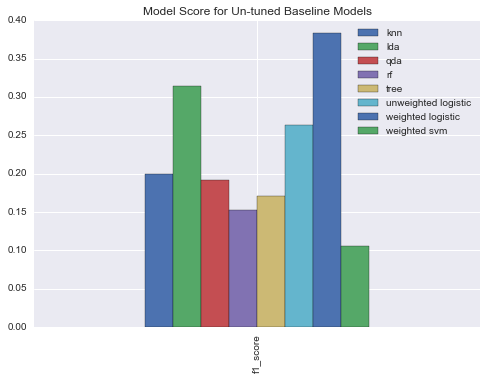

In [113]:
score_df.plot(kind = "bar")
plt.title("Model Score for Un-tuned Baseline Models")

Without feature selection or model tuning, we found that weighted logistic regression gives the best score. Although both random forest and SVM are both very sensitive to model tuning and have space for improvement.

Next, we are going to tune the follwoing three models:
- Weighted Logistic Regression
- RF
- SVM

We'll also perform feature selection.

## 3.2 Weighted Logistic Regression

Best C: 1


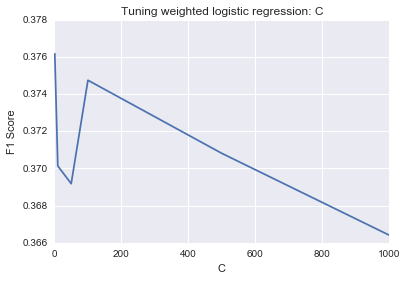

In [250]:
c_best = c[np.argmax(score_weighted_log_tune)]
print 'Best C:', c_best
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(c, score_weighted_log_tune)
plt.xlabel('C')
plt.ylabel('F1 Score')
plt.title('Tuning weighted logistic regression: C')
plt.show()

In [249]:
# weighted logistic regression
genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values

for col in y_train.columns:
    weighted_logistic = LogisticRegression(class_weight='balanced', C = c_best)
    weighted_logistic.fit(x_train, y_train[col])
    genre_pred[col]= weighted_logistic.predict(x_test)

score_weighted_log = f1_genres(y_test, genre_pred)
print "F1 Score of tuned Weighted Logistic Regression:", score_weighted_log

F1 Score of tuned Weighted Logistic Regression: 0.383416268959


#### We also want to tune the parameter C for each columns to optimize its performance:

In [254]:
genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values

for col in y_train.columns:
    k_cv = 5
    score_cv = []
    for i in range(-6, 7, 2):
        # fit regularized logistic regression model on training set      
        weighted_logistic = LogisticRegression(class_weight='balanced', C = 10**i)
        score_cv += [sum(cross_val_score(weighted_logistic, x_train, y_train[col], cv = k_cv, scoring = F_score_cv)) / k_cv]
    # find best score and corresponding tuning parameter
    max_value = max(score_cv)
    max_index = score_cv.index(max_value)
    C_best = 10**(max_index -7)
    print col, C_best
    weighted_logistic = LogisticRegression(class_weight='balanced',  C = C_best)
    weighted_logistic.fit(x_train, y_train[col])
    genre_pred[col]= weighted_logistic.predict(x_test)

score_weighted_log = f1_genres(y_test, genre_pred)
print score_weighted_log

Action 0.001
Adventure 1e-05
Comedy 0.1
Crime 0.0001
Fantasy 0.1
Family 0.0001
Romance 1e-05
Horror 0.0001
Western 0.0001
Documentary 0.01
Biography 1e-05
Drama 0.001
Animation 1e-05
Sci-Fi 0.1
Thriller 0.0001
Short 1e-06
Mystery 1e-05
Sport 0.01
War 1e-05
History 0.01
Music 0.001
Foreign 0.001
Other 1e-05
0.31695870521


#### Functions used in tuning logistic regression:

In [133]:
# function F_score takes model, predictors X and true y values and returns f1_score
# this function is modified to suit cross validation format

def F_score_cv(model, X, y_true):
    y_predict = model.predict(X)
    score = f1_score(y_predict, y_true)
    return score

In [246]:
#### TUNING LOGISTIC REGRESSION #####
#### parameter c (without cross validation)
c = [1, 10, 50, 100, 500, 1000]
score_weighted_log_tune = np.zeros(len(c))
random.seed(0)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.4, random_state=0)

for i in range(len(c)):
    #weighted logistic regression
    genre_pred = pd.DataFrame(index = X_test.index) # dataframe to store predicted values of train

    for col in y_train.columns:
        weighted_logistic = LogisticRegression(class_weight='balanced', C=c[i])
        weighted_logistic.fit(X_train, Y_train[col])
        genre_pred[col]= weighted_logistic.predict(X_test)

    score_weighted_log_tune[i] = f1_genres(Y_test, genre_pred)

## 3.3 Random Forest

In [115]:
# Random Forest
random.seed(0)
rf = RandomForest(n_estimators=100)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
y_pred= pd.DataFrame(y_pred, columns = y_test.columns.values)
score_rf = f1_genres(y_test, y_pred)
print "score of random forest model:",score_rf

score of random forest model: 0.144091737997


In [158]:
feature_rank = pd.DataFrame({'feature':x_train.columns.values, 'importance':rf.feature_importances_})
feature_rank = feature_rank.sort_values(by = 'importance', ascending = False)

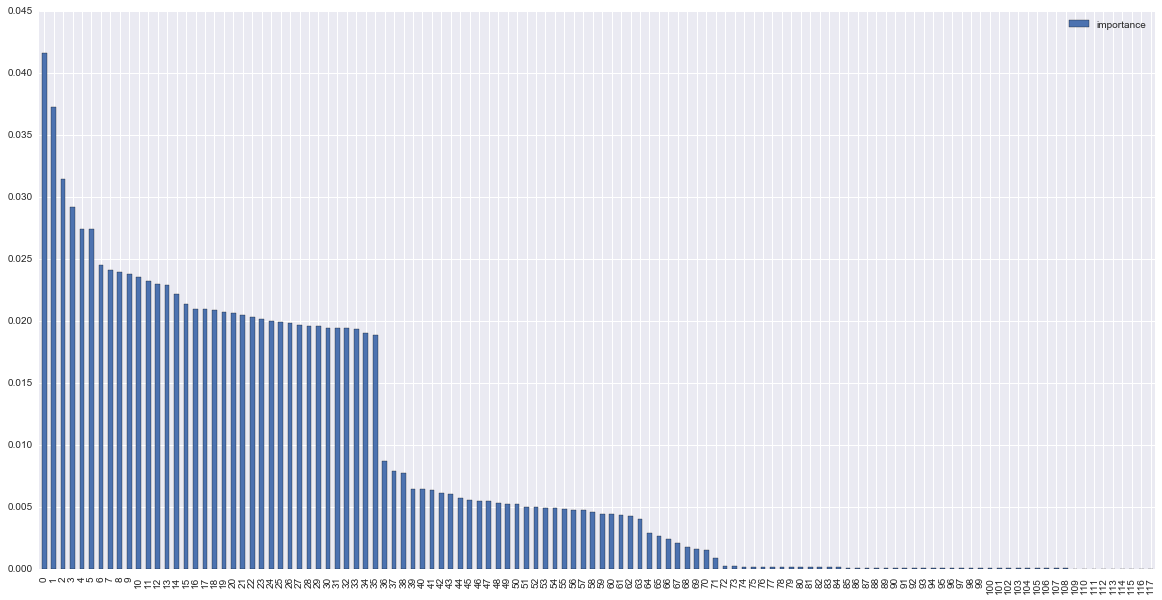

In [159]:
feature_rank.plot(x = 'feature', y = 'importance', kind = 'bar', figsize = (20, 10), use_index = False)
plt.show()

In [161]:
feature_rank[:36]

,feature,importance
4,runtime_TMDB,0.041638
1,rating,0.037289
6,text_PC2,0.031434
9,text_PC5,0.029211
12,text_PC8,0.027413
13,text_PC9,0.027389
2,votes,0.024481
3,popularity_TMDB,0.024120
0,year,0.023958
7,text_PC3,0.023744


#### Acoording to the feature importance, take the first 35 features to train the random forest model:

In [163]:
feature_select = feature_rank.ix[:36, 'feature']

#### F1 score after feature selection:

In [270]:
# Random Forest
random.seed(0)
rf = RandomForest(n_estimators=200)
rf.fit(x_train[feature_select], y_train)
y_pred = rf.predict(x_test[feature_select])
y_pred= pd.DataFrame(y_pred, columns = y_test.columns.values)
score_rf = f1_genres(y_test, y_pred)
print "score of random forest model:",score_rf

score of random forest model: 0.161006388284


Still, there doesn't seem to be hugh improvement.

In [283]:
### Tuning with all the data

## set parameter range for tuning
n_tree = 100
n_feature = [0.2, 0.4, 0.6, 0.8, 1.0]
n_cv = 5

rf_tune = []
   
for i in range(len(n_feature)):
        rf = RandomForest(n_estimators=n_tree, max_features = n_feature[i])
        score = sum(cross_val_score(rf, x_train, y_train, cv = n_cv, scoring = 'f1_macro'))/n_cv
        rf_tune.append(score)

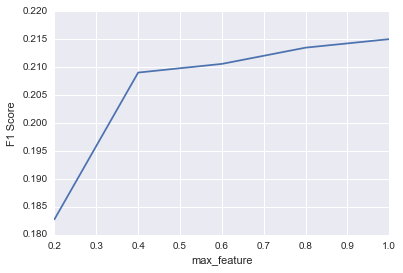

In [287]:
plt.plot(n_feature,rf_tune)
plt.xlabel('max_feature')
plt.ylabel('F1 Score')
plt.show()

In [ ]:
### Tuning with selected feature

## set parameter range for tuning
n_tree = 100
n_feature = [0.2, 0.4, 0.6, 0.8, 1.0]
n_cv = 5

rf_tune = []
   
for i in range(len(n_feature)):
        rf = RandomForest(n_estimators=n_tree, max_features = n_feature[i])
        score = sum(cross_val_score(rf, x_train[feature_select], y_train[feature_select], 
                                    cv = n_cv, scoring = 'f1_macro'))/n_cv
        rf_tune.append(score)

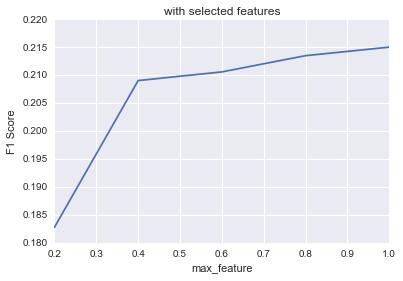

In [288]:
plt.plot(n_feature,rf_tune)
plt.title('with selected features')
plt.xlabel('max_feature')
plt.ylabel('F1 Score')
plt.show()

## 3.4 SVM

In [ ]:
genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values
c = range(-7, 7)

for col in y_train.columns:
    k_cv = 5
    score_cv = []
    for i in range(len(c)):
        # fit regularized logistic regression model on training set      
        svm = SVC(C=10**c[i], class_weight='balanced')
        score_cv += [sum(cross_val_score(svm, x_train, y_train[col], cv = k_cv, scoring = F_score_cv)) / k_cv]
    # find best score and corresponding tuning parameter
    C_best = 10**c[np.argmax(score_cv)]
    print col, C_best
    svm = SVC(class_weight='balanced',  C = C_best)
    svm.fit(x_train, y_train[col])
    genre_pred[col]= svm.predict(x_test)

score_svm = f1_genres(y_test, genre_pred)
print score_svm

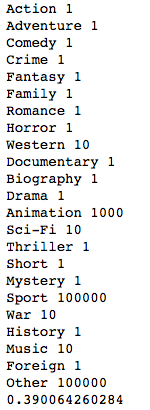

In [245]:
from IPython.display import Image
Image("svm_result.png")

The F1 score of tuned SVM is: 0.390064260284

---
# Part 4. Discussion

### Q. Detailed description and implementation of two different models. Careful performance evaluations for both models.Visualizations of the metrics for performance evaluation.
(please see Part 3 for details in model implementation and evaluation.)
- We briely tested KNN, decision tree, random forest, LQA, DQA, SVM and logistic regression models, without model tuning or feature selection. The baseline models in general

### Q. Description of your performance metrics
(as already be discussed in Part 2)
- For each movie to be predicted, we use the `f1_score` function from `sklearn.metrics` package to compare the predicted value (23-long vector with 0 and 1 for each genre) and true value. To evaluate the model, we use the averaged F1 score.
- We also exlored another metric: Intersection over Union (IoU). Accuracy score here is defined as (intersection between real and predicted vectors) / (union between real and predicted vectors). It also moniters both false positive and false negtive mistakes.

- We choose F1 score because we care about both false positive and false negative mistakes. For now we are giving them the same weights, so we take the harmonic mean of precision and recall. But this can be further adjusted depending on the application of this prediction (whether it's worse to mis-classified a genre or to miss a genre).

### Q. Discussion of the differences between the models, their strengths, weaknesses, etc.
- The weighted logistic regression model and the SVM model seem to have relatively high F1 score (>0.35), while the other models performs poorly.
- The SVM and RF models are computationally expensive, but have larger space to improve (by tuning data). LDA and QDA perform poorply as expected, as much complicated data is less likely to be linearly seperable. The logistic regression is quick and easy to intepretate.

### Q. Discussion of the performances you achieved, and how you might be able to improve them in the future
- The F1 score of different tranditional ML models are generally low. We may need to do seom feature selection, since the total 118 variables may be too much, especially when we are only training on 2500 data points.
- Training the model on a much bigger data set may also help improve (we have 25k data in total).
- We may also want ot include the poster information.